# Curvas Elípticas: Curva de Edward

Propostas em 2007 por _Harold M. Edwards_ em _A normal form for elliptic curves_ (Uma forma normal para curvas elípticas) são uma reformulação das curvas elípticas na forma de Weierstrass que possuem regras para adições mais simples.

As curvas são a soluções da equação:

$$x^2 + y^2 = 1 + d x^2 y^2$$

Com uma constate $d \not \in \{0, 1 \}$, os valores $(x, y, d)$ podem estar em $\mathbb{R}$ ou quando forem utilizados para criptrografia, em um conjunto $F_p$.

As adição de dois pontos $(x_1, y_1) , (x_2, y_2)$ da curva é dado por:

$$
\begin{align}
x_3 = \dfrac{x_1y_2 + x_2y_1}{1 + d x_1 x_2 y_1 y_2} \\
y_3 = \dfrac{y_1y_2 - x_1x_2}{1 - d x_1 x_2 y_1 y_2}
\end{align}
$$

Note a semelhança nos denominadores que possuem ambos o termo $d x_1 x_2 y_1 y_2$.

A seguir há uma implementação da curva de Edward tanto para reais quanto para conjuntos finitos com opções para visualização da curva.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy.ma as ma

In [51]:
class EdwardCurve:
    """
    Implementation of Edward's curve (Edward's form of elliptic curves) for criptography of the form:
    x^2+ y^2 = 1 + d * x^2 * y^2       for d not  in {0, 1}

    It can be created in \mathbb{R} or in a field F_n by using the parameter "field".

    Reference:
        https://en.wikipedia.org/wiki/Edwards_curve#cite_ref-Daniel._J_Bernstein_,_Tanja_Lange_1-0
    """
    def __init__(self, d, field = None):

        assert d != 0 and d != 1

        self.d = d
        self.field = field
        self.points = None
        
    def compute_points(self):
        """
        Compute integers solution in the group Z_n for the curve and save it in a array.
        """
        self.points = []
        limit = int((self.field - 1)/2)
        for i in range(-limit, limit + 1):
            for j in range(i, limit + 1):
                left_side = i*i + j * j
                right_side = 1 + self.d * i * i * j * j
                
                if (left_side - right_side)%self.field == 0:
                    self.points.append([i, j])
                    if i != j:
                        self.points.append([j, i])
                        
        self.points = np.array(self.points)
        
        
    def plot_real(self, ax):
        """
        Plot the function if it is defined on the reals.
        """
        
        #If d < 0, the solution of the equation is inside the square [-1, 1] X [-1, 1]
        # For the fixed value of x in [-1, 1], solve the quadratic equation y^2 (1 - d * x^2) + (x^2 - 1) = 0
        if self.d < 0:
            xs = np.concatenate([
                np.arange(-1, -0.9, 0.01), 
                np.arange(-0.9, -0.1, 0.1),
                np.arange(-0.1, 0.1, 0.01),
                np.arange(0.1, 0.9, 0.1),
                np.arange(0.9, 1.01, 0.01)])

            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))
            xs = np.concatenate([xs, xs[::-1]])
            ys = np.concatenate([ys, -ys[::-1]])
            ax.plot(xs, ys, label = f"d = {self.d}")

        # If d > 1, the possible x vales are on the set S = (-inf, -1) \cup (-1/d, 1/d) \cup (1, inf)
        # For the fixed value of x in S, solve the quadratic equation y^2 (1 - d * x^2) + (x^2 - 1) = 0
        elif self.d > 1:
            xs = np.concatenate([np.arange(-10, -2, 1), np.arange(-2, -1.01, 0.01)])
            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))
            xs = np.concatenate([xs, xs[::-1]])
            ys = np.concatenate([ys, -ys[::-1]])
            
            xs1 = xs.copy()
            ys1 = ys.copy()
            
            xs = np.concatenate([np.arange(1, 2, 0.01), np.arange(2, 10, 1), ])
            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))
            xs = np.concatenate([xs[::-1], xs])
            ys = np.concatenate([ys[::-1], -ys])
            
            xs2 = xs.copy()
            ys2 = ys.copy()

            xs = np.arange(-1/self.d, 1/self.d, 0.01)
            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))
            
            xs3 = xs.copy()
            ys3 = ys.copy()
            xs4 = xs.copy()
            ys4 = -ys.copy()
            
            xs_ = ma.array(np.concatenate([xs1, xs2, xs3, xs4]))
            ys_ = ma.array(np.concatenate([ys1, ys2, ys3, ys4]))
            
            xs_[len(xs1)] = ma.masked
            xs_[len(xs1) + len(xs2)] = ma.masked
            xs_[len(xs1) + len(xs2) + len(xs3)] = ma.masked
            
            ys_[len(ys1)] = ma.masked
            ys_[len(ys1) + len(ys2)] = ma.masked
            ys_[len(ys1) + len(ys2) + len(ys3)] = ma.masked
            
            ax.plot(xs_, ys_, label = f"d = {self.d}")

        # If d in (0, 1), then 1/d > 1, so S = (-inf, -1/d)  \cup (1/d, inf)
        # For the fixed value of x in S, solve the quadratic equation y^2 (1 - d * x^2) + (x^2 - 1) = 0
        else:
            
            xs = np.concatenate([np.arange(-10, -1/self.d -1, 1), np.arange(-1/self.d - 1, -1/self.d, 0.01)])
            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))
            
            xs1 = xs.copy()
            ys1 = ys.copy()
            xs2 = xs.copy()
            ys2 = -ys.copy()

            xs = np.concatenate([np.arange(1/self.d, 1/self.d + 1, 0.01), np.arange(1/self.d + 1, 10, 1), ])
            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))
            
            xs3 = xs.copy()
            ys3 = ys.copy()
            xs4 = xs.copy()
            ys4 = -ys.copy()
            
            xs_ = ma.array(np.concatenate([xs1, xs2, xs3, xs4]))
            ys_ = ma.array(np.concatenate([ys1, ys2, ys3, ys4]))
            
            xs_[len(xs1)] = ma.masked
            xs_[len(xs1) + len(xs2)] = ma.masked
            xs_[len(xs1) + len(xs2) + len(xs3)] = ma.masked
            
            ys_[len(ys1)] = ma.masked
            ys_[len(ys1) + len(ys2)] = ma.masked
            ys_[len(ys1) + len(ys2) + len(ys3)] = ma.masked
            
            ax.plot(xs_, ys_, label = f"d = {self.d}")
        
    def plot_finite_field(self, ax):
        """
        Plot the points of the solution set if the function is defined on a finite field.
        """
        ax.scatter(self.points[:, 0], self.points[:, 1], label = f"d = {self.d}")
        
        
        
    def plot(self, ax = None):
        """
        Controller for plotting function, call the respective function if it is defined in the reals or in a finite field.
        """
        
        if ax == None:
            fig = plt.figure(figsize=(5, 5))
            ax = fig.add_subplot(111) 
            
        if self.field == None:
            self.plot_real(ax)
        else:
            #Verify if points already computed
            if self.points == None:
                self.compute_points()
            self.plot_finite_field(ax)

        
        
    def verify_point(self, P):
        """
        Verify if a point is in a curve (satisfy equation): x^2 + y^2 = 1 + d * x^2 * y^2
        Done both in real or in a finite field.
        """
        left_side = P[0]*P[0] + P[1]*P[1]
        right_side = 1 + self.d * P[0]*P[0] *  P[1]*P[1]
        if self.field == None:
            return left_side == right_side
        else:
            return (left_side - right_side)%self.field == 0
    
        
    def add(self, P, Q, plot = False):
        """
        Add two points from the curve P + Q = R
        """
        
        if not (self.verify_point(P) or self.verify_point(Q)):
            raise Exception("Points not in curve.")
            
        common_term = self.d * P[0] * P[1] * Q[0] * Q[1]
        
        x = (P[0]*Q[1] + P[1]*Q[0]) / (1 + common_term)
        y = (P[1]*Q[1] + P[0]*Q[0]) / (1 - common_term)
        
        R = np.array([x, y])
        
        
    def inverse(self, P, plot = False):
        """
        Return the inverse point of P, i.e., the point Q such that P + Q = 0 
        """
        
        if not (self.verify_point(P)):
            raise Exception("Points not in curve.")
        
        Q = np.array([-P[0], P[1]])
        return Q
    
    def multiply_by_int(self, P, k, plot = False):
        """
        Return the multiplication of point P by int value k, 
        by doing the sum P + P + \dots + P = kP
        """
        
        if not (self.verify_point(P)):
            raise Exception("Points not in curve.")
        
        kP = np.array([0, 1])
        for i in range(k):
            kP = self.sum(kP, P)
            
        return kP

## Curvas nos reais

As curvas definidas em $\mathbb{R}$ possuem diferentes formas características a depender do valor de $d$. Com o valor de $x$ fixo, para compreender a curva precisamos resolver a equação quadrática:

$$ y^2(1 - d x^2) + (x^2 - 1) = 0$$

Que utilizando bhaskara, possui o valor delta:

$$ \Delta = 4(dx^2 - 1)(x^2 - 1)$$

Agora, com $d$ fixo desejamos compreender para quais valores de $x$ tem-se $\Delta > 0$. Tem-se:

- Se $d < 0$, então $\Delta > 0$ para $x \in [-1, 1]$.

- Se $d > 1$, então $\Delta > 0$ para $x \in (-\infty, -1) \cup (-1/d, 1/d) \cup (1, \infty)$.

- Se $d \in (0, 1)$, então $\Delta > 0$ para $x \in (-\infty, -1/d) \cup (1/d, \infty)$ (isto ocorre pois nesse caso $|1/d| > 1$). 

A seguir apresentamos curvas possíveis para os diferentes valores de $d$.

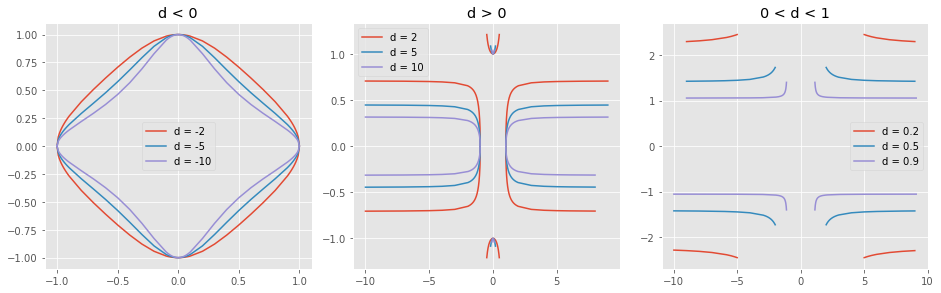

In [52]:
fig, ax = plt.subplots(figsize=(13, 4), nrows = 1, ncols = 3)
plt.tight_layout()

for d in [-2, -5, -10]:
    edc = EdwardCurve(d)
    edc.plot(ax[0])
ax[0].legend()
ax[0].set_title("d < 0")

for d in [2, 5, 10]:
    edc = EdwardCurve(d)
    edc.plot(ax[1])
ax[1].legend()
ax[1].set_title("d > 0")

for d in [0.2, 0.5, 0.9]:
    edc = EdwardCurve(d)
    edc.plot(ax[2])
ax[2].legend()
ax[2].set_title("0 < d < 1")

plt.show()

## Curva em F_43

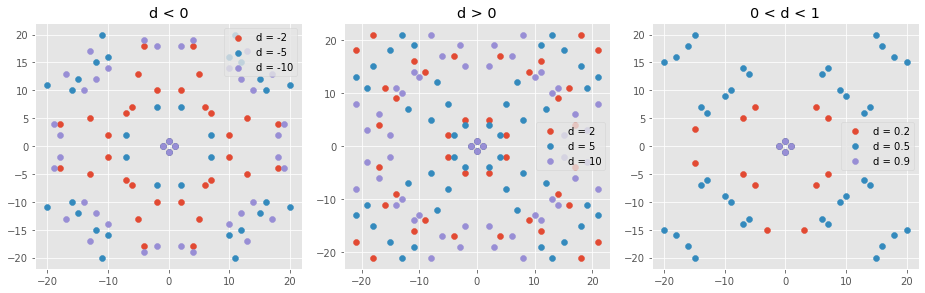

In [53]:
fig, ax = plt.subplots(figsize=(13, 4), nrows = 1, ncols = 3)
plt.tight_layout()

for d in [-2, -5, -10]:
    edc = EdwardCurve(d, 43)
    edc.plot(ax[0])
ax[0].legend()
ax[0].set_title("d < 0")

for d in [2, 5, 10]:
    edc = EdwardCurve(d, 43)
    edc.plot(ax[1])
ax[1].legend()
ax[1].set_title("d > 0")

for d in [0.2, 0.5, 0.9]:
    edc = EdwardCurve(d, 43)
    edc.plot(ax[2])
ax[2].legend()
ax[2].set_title("0 < d < 1")

plt.show()